
 Classification Report:
              precision    recall  f1-score   support

    Original       0.60      0.69      0.64       314
    Tampered       0.63      0.53      0.58       314

    accuracy                           0.61       628
   macro avg       0.61      0.61      0.61       628
weighted avg       0.61      0.61      0.61       628



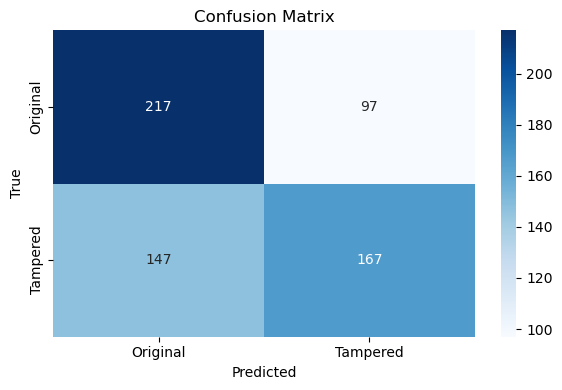

In [1]:
# Evaluating External Validation DataSet (PHASE 4)

import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Defining Model Architecture (The Basic One)
class TamperCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, padding=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 16 * 16, 128), torch.nn.ReLU(), torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1), torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze()

# DataSet for Evaluation
class EvalDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# Updated Paths
original_path = r"C:\Users\imran\OneDrive\Robotics Projects\Image Forgery\Image Data\VALIDATION_CG-1050\VALIDATION\ORIGINAL"
tampered_path = r"C:\Users\imran\OneDrive\Robotics Projects\Image Forgery\Image Data\VALIDATION_CG-1050\VALIDATION\TAMPERED"
original_images = [os.path.join(original_path, f) for f in os.listdir(original_path) if f.lower().endswith(('.jpg', '.png'))]
tampered_images = [os.path.join(tampered_path, f) for f in os.listdir(tampered_path) if f.lower().endswith(('.jpg', '.png'))]
all_paths = original_images + tampered_images
all_labels = [0] * len(original_images) + [1] * len(tampered_images)

# Loading our trained model from PHASE 3
val_dataset = EvalDataset(all_paths, all_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle= False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TamperCNN()
model.load_state_dict(torch.load("tampered_patch_cnn.pth", map_location= device))
model.to(device)
model.eval()

# Evaluating the Model
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

y_pred = np.array(y_pred).astype(int)
y_true = np.array(y_true).astype(int)

# Printing the Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Original", "Tampered"]))

# Generating the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Original", "Tampered"], yticklabels=["Original", "Tampered"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()